In [3]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

In [4]:
ratings = pd.read_csv('ml-latest-small/ratings.csv', sep=',', engine='python')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
movieCols = ['MovieID','Title','Genres']
movies = pd.read_csv('ml-latest-small/movies.csv', sep=',', engine='python')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
Add_names_to_ratings_table = pd.merge(ratings,movies,on='movieId')
drop_col = ['timestamp', 'genres']
# Add_names_to_users_table.head()
# drop
Add_names_to_ratings_table = Add_names_to_ratings_table.drop(drop_col,axis=1)
Add_names_to_ratings_table.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [7]:
Add_names_to_ratings_table = Add_names_to_ratings_table.dropna(axis = 0, subset=['title'])

In [8]:
movie_ratingCount = (Add_names_to_ratings_table.groupby(by = ['title'])['rating'].count().reset_index())
movie_ratingCount.columns = ['title','totalRating']
movie_ratingCount.head()

,title,totalRating
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


In [9]:
rating_with_totalRating = Add_names_to_ratings_table.merge(movie_ratingCount,left_on='title',right_on='title',how='left')
rating_with_totalRating.head()

,userId,movieId,rating,title,totalRating
0,1,1,4.0,Toy Story (1995),215
1,5,1,4.0,Toy Story (1995),215
2,7,1,4.5,Toy Story (1995),215
3,15,1,2.5,Toy Story (1995),215
4,17,1,4.5,Toy Story (1995),215


In [10]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(movie_ratingCount['totalRating'].describe())

count   9719.000
mean      10.375
std       22.406
min        1.000
25%        1.000
50%        3.000
75%        9.000
max      329.000
Name: totalRating, dtype: float64


In [11]:
threshold = 25
rating_popular_movie = movie_ratingCount.query('totalRating >= @threshold').sort_values('title')
print(rating_popular_movie)

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

                                                  title  totalRating
8                           (500) Days of Summer (2009)           42
18                    10 Things I Hate About You (1999)           54
23                                101 Dalmatians (1996)           47
24    101 Dalmatians (One Hundred and One Dalmatians...           44
34                                  12 Angry Men (1957)           57
48                             13th Warrior, The (1999)           26
49                                          1408 (2007)           25
74                         2001: A Space Odyssey (1968)          109
80                                      21 Grams (2003)           25
81                                21 Jump Street (2012)           26
88                                       28 Days (2000)           25
89                                 28 Days Later (2002)           58
104                                          300 (2007)           80
111                               

In [12]:
rating_with_totalRating_pivot = rating_with_totalRating.pivot_table(index='title',columns='userId',values='rating'
                                                                    ,aggfunc=np.mean).fillna(0)
rating_with_totalRating_matrix = csr_matrix(rating_with_totalRating_pivot.values)
print(rating_with_totalRating_pivot)

userId                                               1     2     3     4    \
title                                                                        
'71 (2014)                                         0.000 0.000 0.000 0.000   
'Hellboy': The Seeds of Creation (2004)            0.000 0.000 0.000 0.000   
'Round Midnight (1986)                             0.000 0.000 0.000 0.000   
'Salem's Lot (2004)                                0.000 0.000 0.000 0.000   
'Til There Was You (1997)                          0.000 0.000 0.000 0.000   
'Tis the Season for Love (2015)                    0.000 0.000 0.000 0.000   
'burbs, The (1989)                                 0.000 0.000 0.000 0.000   
'night Mother (1986)                               0.000 0.000 0.000 0.000   
(500) Days of Summer (2009)                        0.000 0.000 0.000 0.000   
*batteries not included (1987)                     0.000 0.000 0.000 0.000   
...All the Marbles (1981)                          0.000 0.000 0

In [13]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine',algorithm = 'brute')
model_knn.fit(rating_with_totalRating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
from tmdbv3api import TMDb, Movie
from imageio import imread
tmdb = TMDb()
tmdb.api_key = 'f85a92e0b3635a045d81d26e262c119d'
tmdb.language = 'en'
tmdb.debug = True
m = Movie()
prefix = 'https://image.tmdb.org/t/p/w200/'


def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [36]:
#query_index = np.random.choice(rating_with_totalRating_pivot.shape[0])
query_index = 3500

distances, indices = model_knn.kneighbors(rating_with_totalRating_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 6)
L = []
s = ""
results = []
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(rating_with_totalRating_pivot.index[query_index]))
        s = rating_with_totalRating_pivot.index[indices.flatten()[i]]
        results = m.search(s[:-6]) 
        suffix = results[0].poster_path
        url = prefix + suffix
        L.append(url)
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, rating_with_totalRating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))
        s = rating_with_totalRating_pivot.index[indices.flatten()[i]]
        results = m.search(s[:-6]) 
        suffix = results[0].poster_path
        url = prefix + suffix
        L.append(url)

Recommendations for Godfather: Part II, The (1974):



INFO:tmdbv3api.tmdb:{'page': 1, 'total_results': 2, 'total_pages': 1, 'results': [{'vote_count': 5983, 'id': 240, 'video': False, 'vote_average': 8.5, 'title': 'The Godfather: Part II', 'popularity': 21.425, 'poster_path': '/bVq65huQ8vHDd1a4Z37QtuyEvpA.jpg', 'original_language': 'en', 'original_title': 'The Godfather: Part II', 'genre_ids': [18, 80], 'backdrop_path': '/gLbBRyS7MBrmVUNce91Hmx9vzqI.jpg', 'adult': False, 'overview': 'In the continuing saga of the Corleone crime family, a young Vito Corleone grows up in Sicily and in 1910s New York. In the 1950s, Michael Corleone attempts to expand the family business into Las Vegas, Hollywood and Cuba.', 'release_date': '1974-12-20'}, {'vote_count': 2948, 'id': 242, 'video': False, 'vote_average': 7.3, 'title': 'The Godfather: Part III', 'popularity': 18.331, 'poster_path': '/1hdm3Axw9LjITbApvAXBbqO58zE.jpg', 'original_language': 'en', 'original_title': 'The Godfather: Part III', 'genre_ids': [80, 18, 53], 'backdrop_path': '/dEuqTwwhfvk66

1: Godfather, The (1972), with distance of 0.17822735875390605:


INFO:tmdbv3api.tmdb:{'page': 1, 'total_results': 47, 'total_pages': 3, 'results': [{'vote_count': 10195, 'id': 238, 'video': False, 'vote_average': 8.6, 'title': 'The Godfather', 'popularity': 26.247, 'poster_path': '/rPdtLWNsZmAtoZl9PK7S2wE3qiS.jpg', 'original_language': 'en', 'original_title': 'The Godfather', 'genre_ids': [18, 80], 'backdrop_path': '/6xKCYgH16UuwEGAyroLU6p8HLIn.jpg', 'adult': False, 'overview': 'Spanning the years 1945 to 1955, a chronicle of the fictional Italian-American Corleone crime family. When organized crime family patriarch, Vito Corleone barely survives an attempt on his life, his youngest son, Michael steps in to take care of the would-be killers, launching a campaign of bloody revenge.', 'release_date': '1972-03-14'}, {'vote_count': 5983, 'id': 240, 'video': False, 'vote_average': 8.5, 'title': 'The Godfather: Part II', 'popularity': 21.425, 'poster_path': '/bVq65huQ8vHDd1a4Z37QtuyEvpA.jpg', 'original_language': 'en', 'original_title': 'The Godfather: Pa

2: Goodfellas (1990), with distance of 0.37845139905963143:


INFO:tmdbv3api.tmdb:{'page': 1, 'total_results': 3, 'total_pages': 1, 'results': [{'vote_count': 5727, 'id': 769, 'video': False, 'vote_average': 8.4, 'title': 'GoodFellas', 'popularity': 20.067, 'poster_path': '/pwpGfTImTGifEGgLb3s6LRPd4I6.jpg', 'original_language': 'en', 'original_title': 'GoodFellas', 'genre_ids': [18, 80], 'backdrop_path': '/sw7mordbZxgITU877yTpZCud90M.jpg', 'adult': False, 'overview': 'The true story of Henry Hill, a half-Irish, half-Sicilian Brooklyn kid who is adopted by neighbourhood gangsters at an early age and climbs the ranks of a Mafia family under the guidance of Jimmy Conway.', 'release_date': '1990-09-12'}, {'vote_count': 17, 'id': 339173, 'video': False, 'vote_average': 8, 'title': "Scorsese's Goodfellas", 'popularity': 2.613, 'poster_path': '/xP5MfmHkRXLrgAYIqI7JtrUPAR5.jpg', 'original_language': 'en', 'original_title': "Scorsese's Goodfellas", 'genre_ids': [99], 'backdrop_path': '/vMps8QKVdNtsph5SJpwNFjNHAPc.jpg', 'adult': False, 'overview': "In this

3: Reservoir Dogs (1992), with distance of 0.405386216524908:


INFO:tmdbv3api.tmdb:{'page': 1, 'total_results': 3, 'total_pages': 1, 'results': [{'vote_count': 7311, 'id': 500, 'video': False, 'vote_average': 8.1, 'title': 'Reservoir Dogs', 'popularity': 28.289, 'poster_path': '/jX94vnfcuJ8rTnFbsoriY6dlHrC.jpg', 'original_language': 'en', 'original_title': 'Reservoir Dogs', 'genre_ids': [80, 53], 'backdrop_path': '/fupyzBwFAn1PoeCXhp54bYVM2ER.jpg', 'adult': False, 'overview': 'A botched robbery indicates a police informant, and the pressure mounts in the aftermath at a warehouse. Crime begets violence as the survivors -- veteran Mr. White, newcomer Mr. Orange, psychopathic parolee Mr. Blonde, bickering weasel Mr. Pink and Nice Guy Eddie -- unravel.', 'release_date': '1992-09-02'}, {'vote_count': 14, 'id': 443129, 'video': False, 'vote_average': 7.5, 'title': 'Reservoir Dogs: Sundance Institute 1991 June Film Lab', 'popularity': 2.225, 'poster_path': '/3eUkmbMnO5XGPoTgXyjUtlBcvwz.jpg', 'original_language': 'en', 'original_title': 'Reservoir Dogs: S

4: One Flew Over the Cuckoo's Nest (1975), with distance of 0.4291311579237137:


INFO:tmdbv3api.tmdb:{'page': 1, 'total_results': 2, 'total_pages': 1, 'results': [{'vote_count': 5568, 'id': 510, 'video': False, 'vote_average': 8.4, 'title': "One Flew Over the Cuckoo's Nest", 'popularity': 17.973, 'poster_path': '/2Sns5oMb356JNdBHgBETjIpRYy9.jpg', 'original_language': 'en', 'original_title': "One Flew Over the Cuckoo's Nest", 'genre_ids': [18], 'backdrop_path': '/4E7YQcwui0PfNXguf4V2X8YocPC.jpg', 'adult': False, 'overview': 'While serving time for insanity at a state mental hospital, implacable rabble-rouser, Randle Patrick McMurphy, inspires his fellow patients to rebel against the authoritarian rule of head nurse, Mildred Ratched.', 'release_date': '1975-11-18'}, {'vote_count': 0, 'id': 328888, 'video': False, 'vote_average': 0, 'title': "The Making of One Flew Over the Cuckoo's Nest", 'popularity': 0.6, 'poster_path': '/5QPt6wuXeqnQhTip04KWwslV4q0.jpg', 'original_language': 'en', 'original_title': "The Making of One Flew Over the Cuckoo's Nest", 'genre_ids': [], 

5: Usual Suspects, The (1995), with distance of 0.4533365068324947:


INFO:tmdbv3api.tmdb:{'page': 1, 'total_results': 2, 'total_pages': 1, 'results': [{'vote_count': 5715, 'id': 629, 'video': False, 'vote_average': 8.2, 'title': 'The Usual Suspects', 'popularity': 16.379, 'poster_path': '/jgJoRWltoS17nD5MAQ1yK2Ztefw.jpg', 'original_language': 'en', 'original_title': 'The Usual Suspects', 'genre_ids': [18, 80, 53], 'backdrop_path': '/c7e3nH3wtSBDrHRB63onrGptl6D.jpg', 'adult': False, 'overview': "Held in an L.A. interrogation room, Verbal Kint attempts to convince the feds that a mythic crime lord, Keyser Soze, not only exists, but was also responsible for drawing him and his four partners into a multi-million dollar heist that ended with an explosion in San Pedro harbor – leaving few survivors. Verbal lures his interrogators with an incredible story of the crime lord's almost supernatural prowess.", 'release_date': '1995-07-19'}, {'vote_count': 0, 'id': 412627, 'video': True, 'vote_average': 0, 'title': 'Doin’ Time with The Usual Suspects', 'popularity':

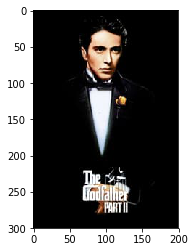

In [ ]:
ImgList = []
for i in range(6):
    image = imread(L[i])
    ImgList.append(image)
plt.imshow(ImgList[0])

show_images(ImgList[1:]);    
# for i in range(6):    
#     poster = Image.fromarray(ImgList[i])
# fig = plt.imshow(poster)    